In [1]:
import sys
sys.path.append('..')

In [8]:
import torch
from copy import deepcopy
import os
from utils import get_config_from_name, prepare_experiment_config,\
     get_merging_fn
from model_merger import ModelMerge
from lmc_utils import interpolate_state_dicts
from graphs.base_graph import NodeType

def validate(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data 
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: \
        {}'.format(100 * correct / total))
    return loss_sum / total, correct / total

In [14]:
config_name = 'test_cca'
device = 'cuda:0'
raw_config = get_config_from_name(config_name, device=device)
# change the model bases to the desired pair
ckpt_dir = '../../Linear_Mode_Connectivity/same_init_ex/cifar10/cifar_vgg16/diff_init/seed_20'
raw_config['model']['bases'][0] = os.path.join(ckpt_dir, 'model_1_160.pt')
raw_config['model']['bases'][1] = os.path.join(ckpt_dir, 'model_2_160.pt')
# prepare models
model_paths = deepcopy(raw_config['model']['bases'])
cur_config = deepcopy(raw_config)
config = prepare_experiment_config(cur_config)
train_loader = config['data']['train']['full']
test_loader = config['data']['test']['full']
base_models = [base_model for base_model in
                config['models']['bases']]
Grapher = config['graph']
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Preparing Models


In [15]:
graphs = [Grapher(deepcopy(base_model)).graphify() for base_model
                    in base_models]
prefix_nodes = []
for node in graphs[0].G.nodes:
    node_info = graphs[0].get_node_info(node)
    if node_info['type'] == NodeType.PREFIX:
        prefix_nodes.append(node)
prefix_nodes = [None] + prefix_nodes
prefix_nodes

[None, 3, 6, 10, 13, 17, 20, 23, 27, 30, 33, 37, 40, 43]

In [30]:
test_acc_s = []
for start_at in prefix_nodes:
    merging_fn = 'match_tensors_cca' # use zipit to match tensors
    graphs = [Grapher(deepcopy(base_model)).graphify() for base_model
                        in base_models]
    Merge = ModelMerge(*graphs, device=device)
    Merge.transform(
        deepcopy(config['models']['new']),
        train_loader,
        transform_fn=get_merging_fn(merging_fn),
        metric_classes=config['metric_fns'],
        stop_at=None,
        start_at=start_at
    )
    test_acc = validate(Merge, test_loader, criterion, device)[1]
    test_acc_s.append(test_acc)

Forward Pass to Compute Merge Metrics: 
Computing transformations: 
Accuracy of the network on the 10000 test images:         76.61
Forward Pass to Compute Merge Metrics: 
Computing transformations: 
Accuracy of the network on the 10000 test images:         77.41
Forward Pass to Compute Merge Metrics: 
Computing transformations: 
Accuracy of the network on the 10000 test images:         74.82
Forward Pass to Compute Merge Metrics: 
Computing transformations: 
Accuracy of the network on the 10000 test images:         77.87
Forward Pass to Compute Merge Metrics: 
Computing transformations: 
Accuracy of the network on the 10000 test images:         74.91
Forward Pass to Compute Merge Metrics: 
Computing transformations: 
Accuracy of the network on the 10000 test images:         83.85
Forward Pass to Compute Merge Metrics: 
Computing transformations: 
Accuracy of the network on the 10000 test images:         85.33
Forward Pass to Compute Merge Metrics: 
Computing transformations: 
Accuracy

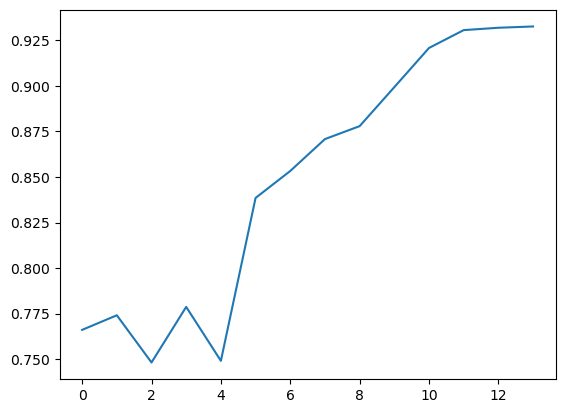

In [36]:
import matplotlib.pyplot as plt

plt.plot(test_acc_s)